# Econometric Forecasts


_In economics, the majority is always wrong_ - John Kenneth Galbraith

- Trends: seasonality, random walk, unit root
- Autocovariance: stationarity, AR, MA, SARIMAX
- Forecasting: single-step, multi-step
- Granger casuality, impulse response function, Vector Autoregression
- Industrial Production


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error        
from finds.readers import Alfred
from secret import credentials
VERBOSE = 0
# %matplotlib qt

In [2]:
series_id, freq, start = 'IPB50001N', 'ME', 0  # not seasonally adjusted
alf = Alfred(api_key=credentials['fred']['api_key'])
df = alf(series_id, log=1, freq=freq, start=start).dropna()
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df.index.freq = freq               # set index to datetime type with 'M frequency
alf.header(series_id)

'Industrial Production: Total Index'

## Seasonality

A time series can be decomposed into three distinct components: the trend, which captures the changes in the level of the time series over time; the seasonal component, which captures predictable changes in the time series according to the time of year; and the cyclical component, which captures the cycles in the data.

Suppose that $Y_t$ is a seasonal time series that has a different mean in each period. The seasonality repeats each $s$ periods (e.g. every 3 in a quarterly series or 12 in a monthly series). Such deterministic seasonalities produce differences in the mean of a time series that are simple to model using dummy variables. 

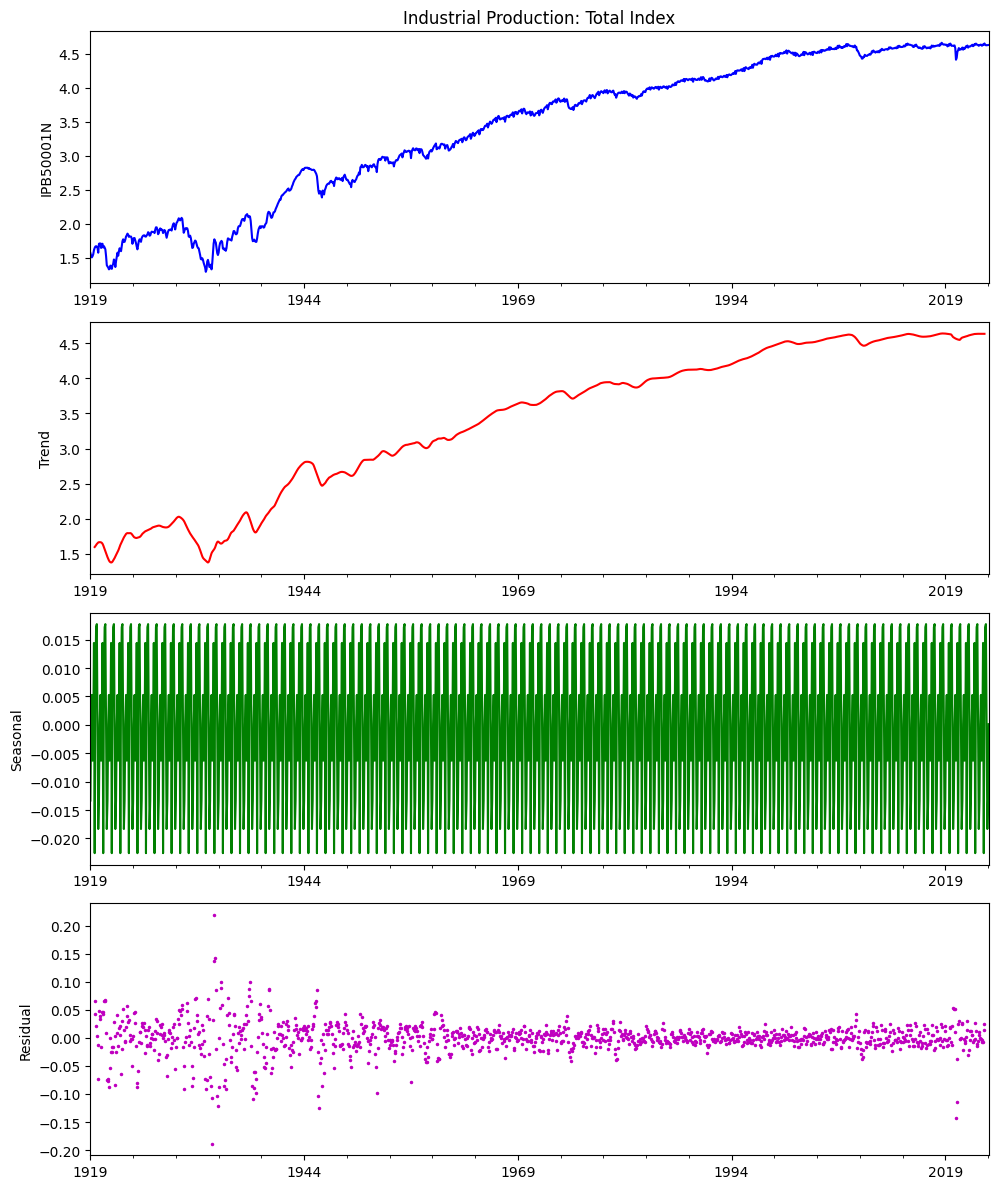

In [3]:
## Seasonality Decomposition Plot
result = seasonal_decompose(df, model = 'add')
fig, ax = plt.subplots(nrows=4, ncols=1, clear=True, figsize=(10, 12))
result.observed.plot(ax=ax[0], title=alf.header(result.observed.name),
                     ylabel=result.observed.name, xlabel='', c='b')
result.trend.plot(ax=ax[1], ylabel='Trend', xlabel='', c='r')
result.seasonal.plot(ax=ax[2], ylabel='Seasonal', xlabel='', c='g')
result.resid.plot(ax=ax[3], ls='', ms=3, marker='.', c='m',
                  ylabel='Residual', xlabel='')
plt.tight_layout()

## Stationarity

Covariance stationarity depends on the first two moments of a time series: the mean and the autocovariances.

Autocovariance is defined as the covariance between a time series observations at different points in time. Its definition is the time-series analog of the covariance between two random variables. The $h$ th autocovariance is defined as:
$\gamma_{t,h} = E[(Y_t - E[Y_t])(Y_{t-h} - E[Y_{t-h}])]$



A time series is covariance-stationary if its first two moments satisfy three key properties. 
1. The mean is constant and does not change over time (i.e., $E[Y_t] = m$ for all t).
2. The variance is finite and does not change over time (i.e., $V[Y_t] = \gamma_0 < \infty$ for all $t$).
3. The autocovariance is finite, does not change over time, and only depends on the distance between observation $h$ (i.e., $Cov[Y_t, Y_{t-h}] = \gamma_h$ for all $t$).

Covariance stationarity is important when modeling and forecasting time series. A covariance-stationary time series has constant relationships over time.


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
less than a critical size, then we can reject that there is a unit root.

In [4]:
values = df.diff().dropna().values.squeeze()
adf = adfuller(values)
DataFrame.from_dict({"I(1)": list(adf[:4]) + list(adf[4].values())},
                    orient='index',
                    columns=(['Test Statistic', 'p-value', 'Lags Used', 'Obs Used'] +
                             [f"critical({k})" for k in adf[4].keys()])).round(3)

,Test Statistic,p-value,Lags Used,Obs Used,critical(1%),critical(5%),critical(10%)
I(1),-7.235,0.0,23,1237,-3.436,-2.864,-2.568


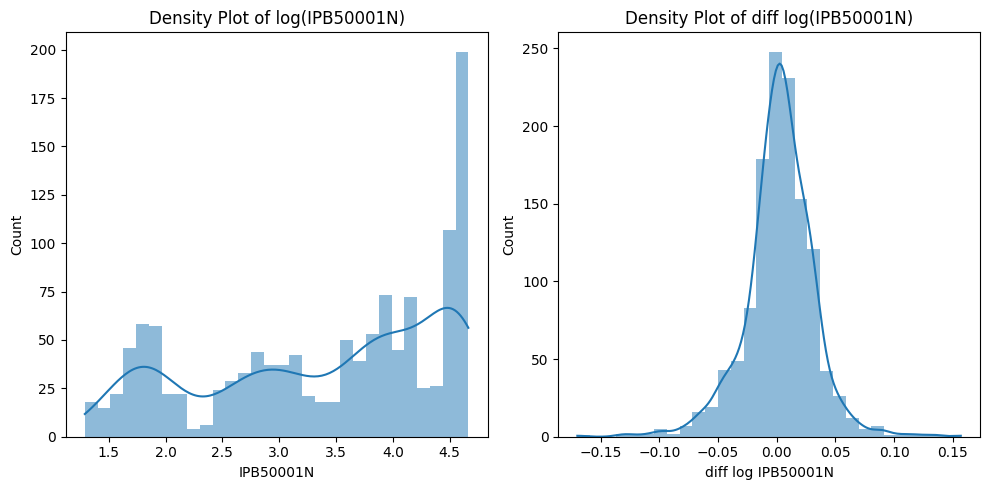

In [5]:
# Histogram Plot and Kernel Density Estimate
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
sns.histplot(df.dropna(), bins=30, lw=0, kde=True, ax=axes[0])
axes[0].set_title(f"Density Plot of log({series_id})")
sns.histplot(df.diff().dropna().rename(f"diff log {series_id}"),
             bins=30, lw=0, kde=True, ax=axes[1]) #line_kws={"color": "r"}
axes[1].set_title(f"Density Plot of diff log({series_id})")
plt.tight_layout()

## Autocorrelation 

The autocorrelation at lag $h$ is defined as the ratio:
$\rho_h = \dfrac{\gamma_h}{\gamma_0}$. The partial autocorrelation measures the strength of the correlation between these two time-series observations after controlling for the observations between them (i.e., the intermediate lags $Y_{t-1}, Y_{t-2}, ..., Y_{t-h+1}$).

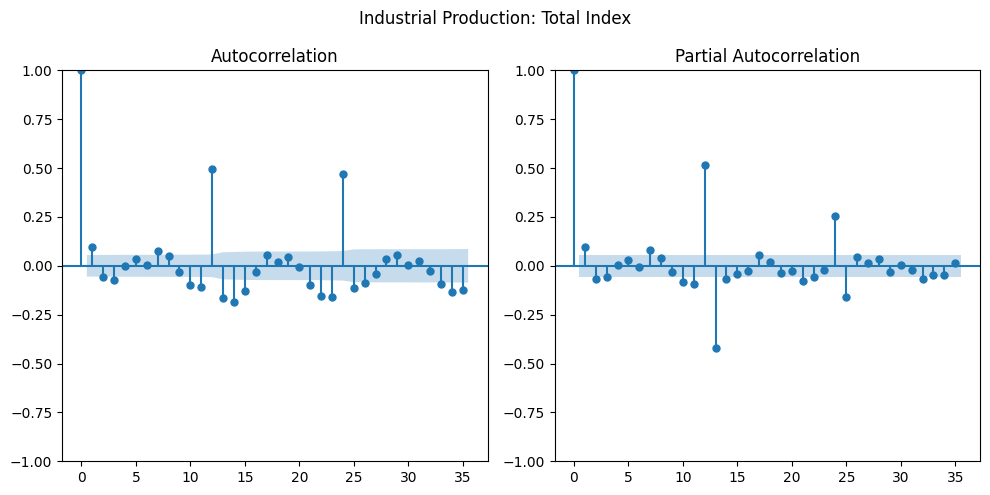

In [6]:
values = df.diff().dropna().values.squeeze()
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
plot_acf(values, lags=35, ax=axes[0])
plot_pacf(values, lags=35, ax=axes[1], method='ywm')
plt.suptitle(alf.header(result.observed.name))
plt.tight_layout()

## Time Series


### AR models
__Autoregressive__ models relate the current value of a time series $Y_t$ to its previous values. A first order AR process, which can be denoted by AR(1), evolves according to: $Y_t = \delta + \phi Y_{t-1} + \epsilon_t$,
where $\delta$ is called the intercept, $\phi$ is the AR parameter, and the shock $\epsilon$ is white noise with constant and finance variance $\sigma^2$.
White noise processes have zero autocorrelation and autocovariance

It partial autocorrelation function (__PACF__) is non-zero only for the first lag, while its autocorrelation function (__ACF__) exhits a slow decay $\rho(h) = \phi^{|h|}$

The $p$ th order AR process generalizes the first-order process to include $p$ lags of $Y$ in the model. The AR(p) model is: $Y_t = \mu + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \epsilon_t$



### MA models

A first-order __moving average__ model, denoted MA(1), is defined as: 
$Y_t = \mu + \theta \epsilon_{t-1} + \epsilon_t$

The observed value of $Y_t$ depends on both the contemporaneous and previous shock. Moving averages are always covariance-stationary. An MA(1) has a limited memory, because only the shock in the previous period impacts the current value.

The MA(1) generalizes to an MA(q), which includes $q$ lags of the shock:
$Y_t = \mu + \epsilon_t + \phi_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$

Its ACF is always zero for lags larger than $q$, but the PACF is more complex.

### ARMA models

Autoregressive Moving Average (ARMA) processes combine AR and MA processes. For example, a simple ARMA(1,1) evolves according to:
$Y_t = \mu + \phi Y_{t-1} + \theta epsilon_{t-1} + \epsilon_{t}$
The mean of this process is $\mu = \delta / (1 - \phi)$
The variance is $\gamma_0 = \sigma^2(1 + 2\phi \theta + \theta^2)/(1 - \phi^2)$

An ARMA(1,1) process is covariance-stationary if $|\phi_1| <> 1$. The MA coefficient plays no role in determining whether the pro-cess is covariance-stationary, because any MA is covariance-stationary and the MA component only affects a single lag of the shock. The AR component, however, affects all lagged shocks and so if $\phi_1$ is too large, then the time series is not covariance-stationary.



### Lag lengths

Determining the appropriate lag lengths for the AR and MA components (i.e., p and q, respectively) is a key challenge when building an ARMA model. The first step in model building is to inspect the sample autocorrelation and sample PACFs. 

The __Box-Pierce__ test statistic is the sum of the squared autocorrelations scaled by the sample size T: $Q_{BP} = T\sum_{i=1}^h (\dfrac{T+1}{T-1}) \hat{\rho}_i^2$
When the null is true, $Q_{BP}$ is asymptotically distributed as a $\chi_h^2$ variable.  

The __Ljung-Box__ statistic is a modified version of the Box-Pierce statistic that works better in smaller samples, and is defined as: $Q_{LB} = T\sum_{i=1}^h (\dfrac{T+2}{T-i}) \hat{\rho}_i^2$





### Seasonal component
Seasonal components can be added to the short-term components of an ARMA(p,q) model, by using lags only at the seasonal frequency.  A seasonal ARMA combines
these two components into a single specification: 

$$ARMA (p, q) \times (p_s, q_s)_f$$

where p and q are the orders of the short-run lag polynomials, $p_s$ and $q_s$ are the orders of the seasonal lag polynomials, and $f$ is the seasonal horizon (e.g., every 3 or 12 months with monthly observations).



### Unit Roots
Random walks are most important source of non-stationarity in economic time series. A simple random walk process evolves according to:
$Y_t = Y_{t-1} + \epsilon_t$. Unit roots generalize random walks by adding short-run station-ary dynamics to the long-run random walk.

A pair of time series have a spurious relationship when there are no fundamental links between them, but a regression of one on the other produces a coefficient estimate that is large and seemingly statistically different from zero when using conventional statistical distributions to obtain the critical values. When a time series contains a unit root, it is common to find spurious relationships with other time series that have a time trend or a unit root.

The solution is to difference a time series that contains a unit root. If $Y_t$ has a unit root (i.e. has integration order 1), then the difference: $\Delta Y_t = Y_t - Y_{t-1}$ does not.


### SARIMAX model

The Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model is specified $(p, d, q) \times (P, D, Q)_s$, with

- the (p,d,q) order of the model for the number of AR parameters, differences (indicating the integration order of the process), and MA parameters,

- the (P,D,Q,s) order of the seasonal component for the AR parameters, differences, MA parameters, and periodicity.


In [7]:
split_date = df.index[-12]   # train/test split date
# df_train = df.loc[:split_date].dropna()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09203D+00    |proj g|=  3.50751D-01

At iterate    5    f= -2.09212D+00    |proj g|=  2.65613D-02

At iterate   10    f= -2.09214D+00    |proj g|=  1.27872D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   8.002D-04  -2.092D+00
  F =  -2.0921435906737225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              IPB50001N   No. Observations:                 1262
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2640.285
Date:                Tue, 09 Apr 2024   AIC                          -5272.570
Time:                        11:16:42   BIC                          -5252.012
Sample:                    01-31-1919   HQIC                         -5264.845
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      2.393      0.017       0.000       0.005
ar.L1         -0.1199      0.222     -0.541      0.588      -0.554       0.314
ma.L1          0.2237      0.221      1.011      0.312      -0.210       0.657
sigma2         0.0009   2.24e-05     39.741      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               554.43
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

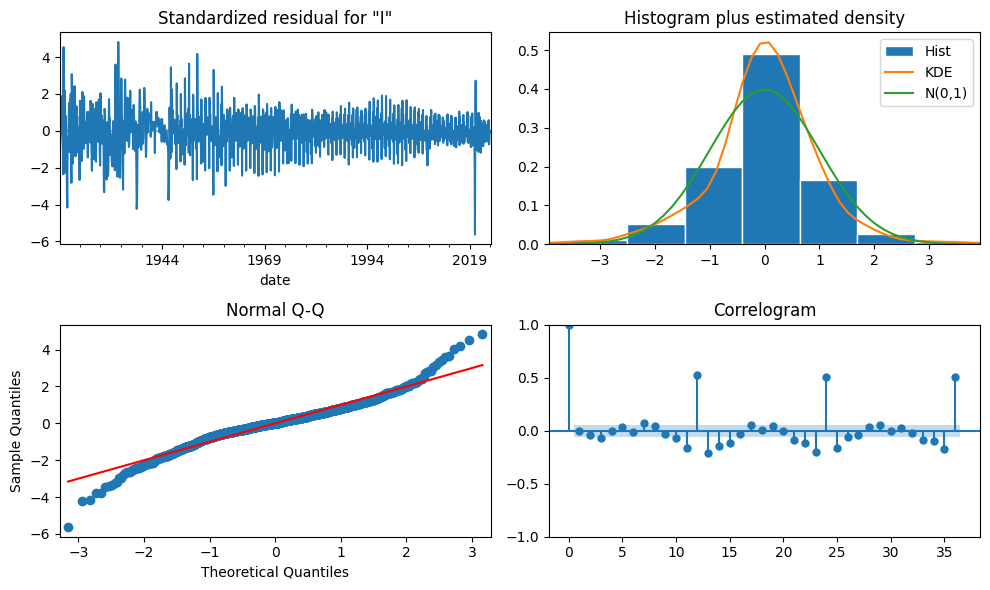

In [8]:
# Fit a SARIMA(1,1,3) with seasonal order (0, 0, 0, 12)
pdq = (1, 1, 1)   #(12, 1, 0)
seasonal_pdqs = (0, 0, 0, 12)
arima = SARIMAX(df, order=pdq, seasonal_order=seasonal_pdqs, trend='c').fit()
fig = arima.plot_diagnostics(figsize=(10, 6), lags=36)
plt.tight_layout()
arima.summary()

## Forecasting

In [9]:
series_id, start = 'INDPRO', 0
df_all = alf(series_id, log=1, diff=1, start=start).dropna()
df_all.index = pd.to_datetime(df_all.index, format='%Y%m%d')
df_all.index.freq = freq
df_train = df_all[df_all.index <= split_date]
df_test = df_all[df_all.index > split_date]

### AR lag order

The most natural measure of fit is the sample variance of the estimated residuals, also known as the Mean Squared Error (MSE) of the model. Unfortunately, choosing a model to minimize MSE also selects a specification that is far too large. The solution to this overfitting problem is to add a penalty to the MSE that increases each time a new parameter is added.

- AIC is defined as: AIC = $T \ln \hat{\sigma}^2 + 2 k$, where T is the sample size and k is the number of parameters. 
- BIC alters the penalty and is defined as: BIC = $T \ln \hat{\sigma}^2 2 + k \ln T$ 

Unlike the AIC, the BIC has a cost per parameter that slowly increases with T. Hence BIC always selects a model that is no larger than the model selected by the AIC (assuming $\ln T > 2$), and is a consistent model selection criterion (i.e., the true model is selected as $T \rightarrow \infty$).


In [10]:
lags = ar_select_order(df_train, maxlag=36, ic='bic', old_names=False).ar_lags
print('(BIC) lags= ', len(lags), ':', lags)

(BIC) lags=  1 : [1]


In [11]:
# Train final model on train split
model = AutoReg(df_train, lags=lags, old_names=False).fit()  
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                 1250
Model:                     AutoReg(1)   Log Likelihood                3331.030
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Tue, 09 Apr 2024   AIC                          -6656.061
Time:                        11:16:45   BIC                          -6640.670
Sample:                    03-31-1919   HQIC                         -6650.275
                         - 03-31-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.697      0.007       0.000       0.002
INDPRO.L1      0.4854      0.025     19.685      0.000       0.437       0.534
                                    Roots           

### One-step forecast

The one-step forecast is the expectation of $Y_{T+ 1}$ conditional the time T information set, which contains all values that are known at time T, including the entire prior history of Y ($Y_T, Y_{T-1}, ... $), as well as all values of any other variable that occurred at time T or earlier. 

In [12]:
# Observations to predict are from the oos test split
test = AutoReg(df_all, lags=lags, old_names=False)

In [13]:
# Use model params from train split, start predictions from last train row    
df_pred = test.predict(model.params, start=df_test.index[0])
mse = mean_squared_error(df_test, df_pred)
#var = np.mean(np.square(df_test - df_train.mean()))
print(f"ST Forecast({len(df_pred)}): rmse={np.sqrt(mse)}")

ST Forecast(11): rmse=0.006210397949646384


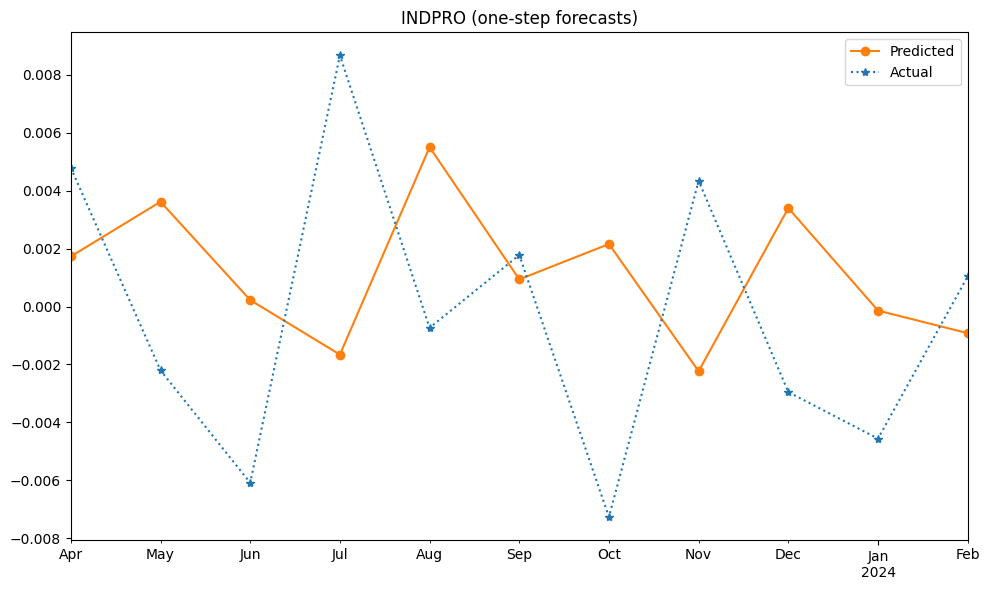

In [14]:
fig, ax = plt.subplots(clear=True, num=1, figsize=(10, 6))
df_pred.plot(ax=ax, c='C1', ls='-', marker='o', label='Predicted')
df_test.plot(ax=ax, c='C0', ls=':', marker='*', label='Actual')
ax.legend()
ax.set_title(series_id + " (one-step forecasts)")
ax.set_xlabel('')
plt.tight_layout()

### Multi-step forecast

Forecasts are generated recursively starting with $E_T[Y_{T+ 1}]. The forecast at horizon h depends on forecasts from earlier steps ($E_T[Y_{T+ 1}], ..., E_T [Y_{T+ h - 1}]). When these
quantities appear in the forecast for period $T + h$, they are replaced by the forecasts computed for horizons $1, 2, ... , h - 1$.




Long-term Forecasts:  rmse=0.005469


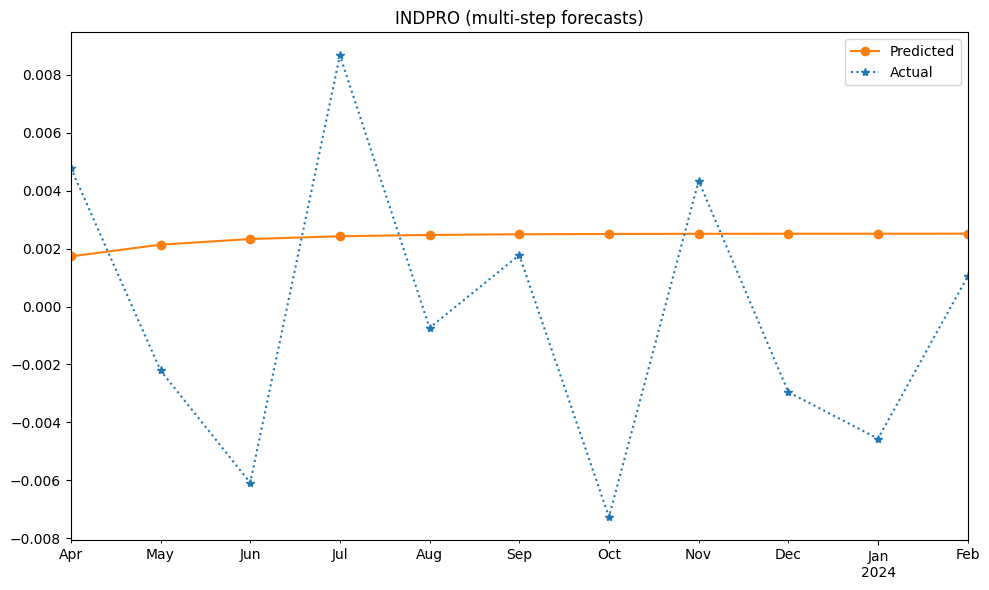

In [15]:
# set dynamic=True for multi-step ahead predictions
df_pred = test.predict(model.params, dynamic=True,
                       start=df_test.index[0], end=df_test.index[-1])
mse = mean_squared_error(df_test, df_pred)
#var = np.mean(np.square(df_test - df_train.mean()))
print(f"Long-term Forecasts:  rmse={np.sqrt(mse):.6f}")
fig, ax = plt.subplots(clear=True, num=2, figsize=(10, 6))
df_pred.plot(ax=ax, c='C1', ls='-', marker='o', label='Predicted')
df_test.plot(ax=ax, c='C0', ls=':', marker='*', label='Actual')
ax.legend()
ax.set_title(series_id + " (multi-step forecasts)")
ax.set_xlabel('')
plt.tight_layout()

### Granger Causality

In [16]:
# Granger Causality: INDPRO vs CPI
variables = ['INDPRO', 'CPIAUCSL']
start = 19620101
for series_id, exog_id in zip(variables, list(reversed(variables))):
    df = pd.concat([alf(s, start=start, log=1)
                    for s in [series_id, exog_id]], axis=1)
    df.index = pd.DatetimeIndex(df.index.astype(str))
    df.index.freq = freq
    data = df.diff().dropna()

    print(f"Null Hypothesis: {exog_id} granger-causes {series_id}")
    res = grangercausalitytests(data, maxlag=3)
    print()

    dmf = (f'{series_id} ~ {series_id}.shift(1) '
           f' + {exog_id}.shift(1) '
           f' + {exog_id}.shift(2) '
           f' + {exog_id}.shift(3) ')
    model = smf.ols(formula=dmf, data=data).fit()
    robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
    print(robust.summary())

Null Hypothesis: CPIAUCSL granger-causes INDPRO

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3694  , p=0.5435  , df_denom=741, df_num=1
ssr based chi2 test:   chi2=0.3709  , p=0.5425  , df=1
likelihood ratio test: chi2=0.3708  , p=0.5426  , df=1
parameter F test:         F=0.3694  , p=0.5435  , df_denom=741, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5604  , p=0.0006  , df_denom=738, df_num=2
ssr based chi2 test:   chi2=15.2233 , p=0.0005  , df=2
likelihood ratio test: chi2=15.0694 , p=0.0005  , df=2
parameter F test:         F=7.5604  , p=0.0006  , df_denom=738, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3906  , p=0.0011  , df_denom=735, df_num=3
ssr based chi2 test:   chi2=16.3259 , p=0.0010  , df=3
likelihood ratio test: chi2=16.1489 , p=0.0011  , df=3
parameter F test:         F=5.3906  , p=0.0011  , df_denom=735, df_num=3

                            OLS Regression Re

### Impulse Response Function

- Vector Autoregresion (VAR)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Apr, 2024
Time:                     11:16:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.3130
Nobs:                     742.000    HQIC:                  -21.3664
Log likelihood:           5847.68    FPE:                5.08298e-10
AIC:                     -21.4000    Det(Omega_mle):     4.98842e-10
--------------------------------------------------------------------
Results for equation CPIAUCSL
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000906         0.000141            6.439           0.000
L1.CPIAUCSL         0.542635         0.036649           14.806           0.000
L1.INDPRO           0.005496         0.009885            0.556   

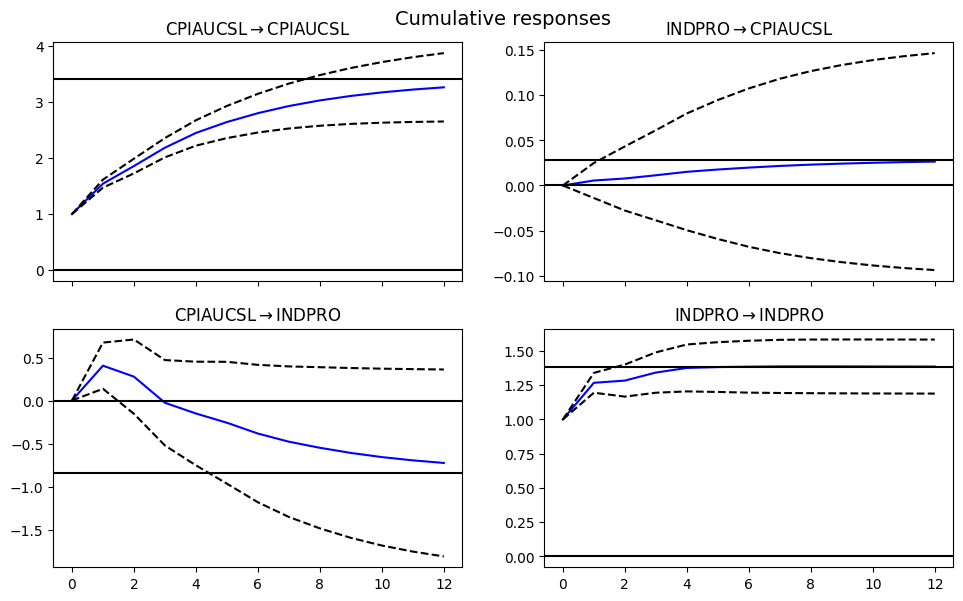

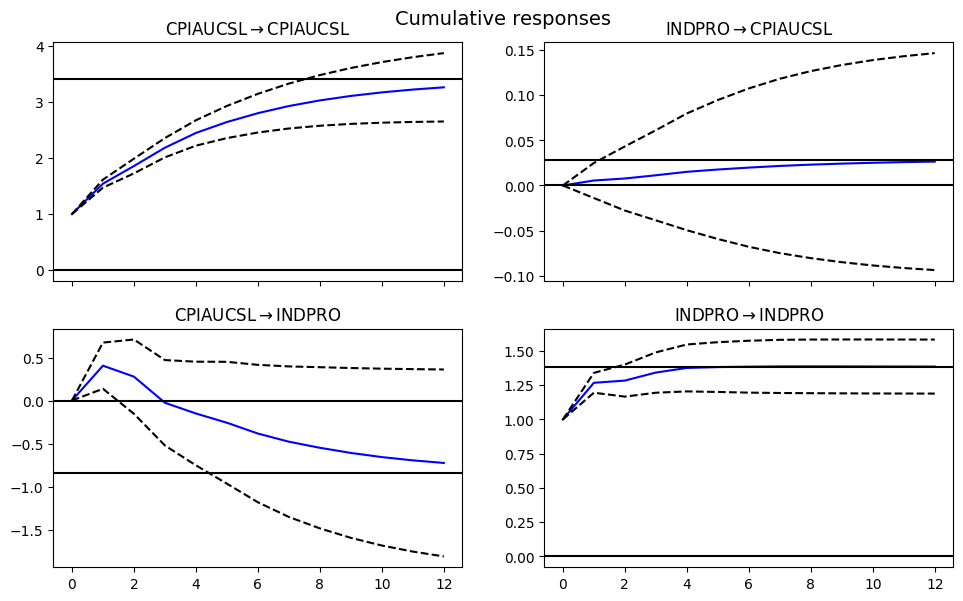

In [17]:
# Vector Autoregression: Impulse Response Function
model = VAR(data)
results = model.fit(maxlags=3)
print(results.summary())
irf = results.irf(12)
#irf.plot(orth=False)
irf.plot_cum_effects(orth=False, figsize=(10, 6))